In [3]:
#Data Plotting - 31/01/2022 - zpau
#
#
#First, we read the datafiles
from read_CTD import read_CTD   #function we created to read the CTD files
data_dirs =  ['C:/Users/Pau/Data/TFM/CTD_proc_files_1mbin/']   #path of the datafiles
data = read_CTD(data_dirs)
#
#Now, we start with the plotting of vertical profiles

In [86]:
#Vertical Profiles - zpau - 31/01/2022
#Code that creates a function to plot vertical profiles form different variables (up to 3)
def vert_profile(data, ncast, *variables, figsize=(5,9), colors=['red', 'blue', 'orange'], savefig=False):
    """Function to plot a vertical profile of different
    variables (up to 3) for a particular station (ncast)
    data -> dictionary where the CTD dataframes are stored
            according to its ncast
    *variables -> strings of the variable names to plot
    savefig -> if we want to save the fig -> savefig=True
    examples:
    1 variable plot -> vert_profile(data, '09', 'temperature')
    2 variable plot -> vert_profile(data, '09', 'temperature', 'salinity')
    """
    #Imports
    import matplotlib.pyplot as plt
    #1 variable
    if len(variables) == 1:
        data[ncast][variables[0]].plot_cast()
        plt.title(variables[0]+' '+ncast)
        plt.show
    #2 variables
    if len(variables) == 2:
        ax0 = data[ncast][variables[0]].plot_cast(color=colors[0])
        ax1 = data[ncast][variables[1]].plot_cast(
            ax=ax0, color=colors[1], secondary_y=True)
        lines = ax0.get_lines() + ax1.get_lines()
        leg = {
            line: line.get_label() for line in lines
        }
        ax0.legend(leg.keys(), leg.values(), loc='lower center')
        ax0.grid(False)
        ax1.grid(False)
        plt.title('Vertical Profile '+ncast)
        plt.show
    #3 variables
    if len(variables) == 3:
        #Create a function to make invisible an axis line
        def make_patch_spines_invisible(ax):
            ax.set_frame_on(True)
            ax.patch.set_visible(False)
            for sp in ax.spines.values():
                sp.set_visible(False)
        fig, ax0 = plt.subplots(figsize=figsize)
        colors = colors
        ax0.invert_yaxis()
        ax1 = ax0.twiny()
        ax2 = ax0.twiny()
        #plotting
        l0, = ax0.plot(data[ncast][variables[0]], data[ncast].index, color=colors[0], label=variables[0])
        ax0.set_xlabel(variables[0])
        l1, = ax1.plot(data[ncast][variables[1]], data[ncast].index, color=colors[1], label=variables[1])
        ax1.set_xlabel(variables[1])
        l2, = ax2.plot(data[ncast][variables[2]], data[ncast].index, color=colors[2], label=variables[2])
        ax2.set_xlabel(variables[2])
        make_patch_spines_invisible(ax2)     #ax2 invisible
        ax2.spines['top'].set_position(('axes', 1.1))    #ax2 elevated
        ax2.spines['top'].set_visible(True)
        #Coloring the axis
        ax0.xaxis.label.set_color(l0.get_color())
        ax1.xaxis.label.set_color(l1.get_color())
        ax2.xaxis.label.set_color(l2.get_color())
        ax0.tick_params(axis='x', colors=l0.get_color())
        ax1.tick_params(axis='x', colors=l1.get_color())
        ax2.tick_params(axis='x', colors=l2.get_color())
        lines = ax0.get_lines() + ax1.get_lines() + ax2.get_lines()
        leg = { line: line.get_label() for line in lines }     #Dict that stores the labels from the axis (keys)
        ax0.legend(leg.keys(), leg.values(), loc='lower center')
        ax0.grid(False)
        ax1.grid(False)
        ax2.grid(False)
        plt.title('Vertical Profile '+ncast)
        plt.show
    #To save the plot
    if savefig == True:
        if len(variables)==1:
            plt.savefig('vert_profile_'+ncast+'_'+variables[0]+'.png')
        if len(variables)==2:
            plt.savefig('vert_profile_'+ncast+'_'+variables[0]+'_2var.png')
        if len(variables)==3:
            plt.savefig('vert_profile_'+ncast+'_'+variables[0]+'_3var.png')

In [107]:
#T-S - zpau - 31/01/2022
#Code that creates a function that plots a T-S diagram
#
def plot_TS(data, n_list, figsize=(7,7), savefig=False):
    """Function to plot a T-S diagram from one or more stations
    data -> dict that stores the CTD DFs by its ncast
    n_list -> LIST of the ncast stations to plot
    example:
    1 station -> plot_TS(data, ['09'])
    more stations -> plot_TS(data, ['09','10','11','12'])
    """
    #Imports
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import gsw
    
    #Concatenate the DFs
    data_conc = pd.DataFrame()   
    for ncast in n_list:
        if data_conc.empty:
            data_conc = data[ncast]
        else:
            data_conc = pd.concat([data_conc, data[ncast]])
    
    #Limits of the variables to plot
    smin = data_conc['salinity'].min() - (0.01 * data_conc['salinity'].min())
    smax = data_conc['salinity'].max() + (0.01 * data_conc['salinity'].max())
    tmin = data_conc['pot_temperature'].min() - (0.1 * data_conc['pot_temperature'].max())
    tmax = data_conc['pot_temperature'].max() + (0.1 * data_conc['pot_temperature'].max())
    
    # Calculate how many gridcells we need in the x and y dimensions
    xdim = int(round((smax-smin)/0.1+1,0))
    ydim = int(round((tmax-tmin)+1,0))
    
    # Create empty grid of zeros
    dens = np.zeros((ydim,xdim))
    
    # Create temp and salt vectors of appropiate dimensions
    ti = np.linspace(1,ydim-1,ydim)+tmin
    si = np.linspace(1,xdim-1,xdim)*0.1+smin
    # Loop to fill in grid with densities
    for j in range(0,int(ydim)):
        for i in range(0, int(xdim)):
            ct_i = gsw.CT_from_pt(si[i], ti[j])
            dens[j,i]=gsw.sigma0(si[i],ct_i)       
            
    #Plotting
    fig1 = plt.figure(figsize=figsize)
    ax1 = fig1.add_subplot(111)
    CS = plt.contour(si,ti,dens, linestyles='dotted', linewidths = [1,1,1,1,1,1], colors='k')   #Density contours
    plt.clabel(CS, fontsize=12, inline=1, fmt='%1.1f') # Label every second level
    plt.scatter(data_conc['salinity'], data_conc['pot_temperature'], c='blue', s=10)   #T-S plot
    ax1.set_xlabel('Salinity (psu)')
    ax1.set_ylabel('Potential Temperature (C)')
    plt.title('T-S '+'from station ncast '+n_list[0]+' to '+n_list[-1])
    if savefig == True:
        plt.savefig('TS_'+n_list[0]+'to'+n_list[-1]+'.png')
    plt.show()

In [110]:
#PLOTTING VERTICAL SECTIONS - zpau - 31/01/2022
#The following code creates a function to plot simple vertical sections 
#The bathymetry is not considered and the X axis respresent the longitudes, not the distances
#
#
def vert_section(data, n_list, variable, function_interp, cmap, ncontours=5, figsize=(10,5), savefig=False):
    """ Function that plots a vertical section of the n_list stations.
    The bathymetry is not considered.
    X axis represent longitudes, not the distances.
    The interpolation used is the scipy.interpolate.Rbf()
    arguments:
    data -> dict that stores the CTD DFs by its ncast
    n_list -> LIST of the stations ncast to plot
    variable -> string of the variable to represent
    function_interp -> string of the interpolation typology:
        ('multiquadric','inverse','gaussian','linear','cubic','quintic','thin_plate')
    cmap -> mesh colouring
    ncontours -> number of contours
    """
    #Imports
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import cmocean
    import scipy.interpolate
    #Store the longitudes of the stations
    station_longs=[]
    for n in n_list:
        station_longs.append(data[n]['longitude'].iloc[0])
    #limits of the section
    xoffset = 0.03
    sect_start_lon = station_longs[0] + xoffset
    sect_fin_lon = station_longs[-1] - xoffset
    #Concatenate the DFs of the stations to store all the data in just one DF
    data_conc = pd.DataFrame()   
    for n in n_list:
        if data_conc.empty:
            data_conc = data[n]
        else:
            data_conc = pd.concat([data_conc, data[n]])
    #Minimum and maximum values of the axis to create the mesh/grid
    minlon = data_conc['longitude'].min()
    maxlon = data_conc['longitude'].max()
    mindepths = data_conc['depth'].min()
    maxdepths = data_conc['depth'].max()
    #Plotting
    fig, ax = plt.subplots(figsize=figsize)    
    plt.xlim(sect_start_lon, sect_fin_lon)
    plt.ylim(data_conc['depth'].max()+500, 0)
    #Fuction of the interpolate
    interp = scipy.interpolate.Rbf(data_conc['longitude'], data_conc['depth'], data_conc[variable], function=function_interp)
    #Creation of the 2D grip (100j -> 100 steps)
    xi, yi = np.mgrid[minlon-xoffset:maxlon + xoffset:100j, mindepths:maxdepths:100j]
    #Interpolation
    zi = interp(xi,yi)
    #Creation of the color mesh
    handle2 = ax.pcolormesh(xi,yi,zi, vmin=data_conc[variable].min(), vmax=data_conc[variable].max(), cmap=cmap, shading='auto')
    #Plot the CTD soundings
    a = plt.scatter(data_conc['longitude'], data_conc['depth'], c='grey', s=2)
    #Plot the contours
    CS = ax.contour(xi,yi,zi, levels=ncontours, colors='k', linewidths=0.75)
    #Label the contours
    ax.clabel(CS, CS.levels, inline=True, fmt='%1.1f', fontsize=8)
    fig.colorbar(handle2)
    ax.margins(0.05)
    plt.title('Vertical Section of '+variable+' from '+nlist[0]+' to '+nlist[-1])
    #To save the plot
    if savefig == True:
        plt.savefig('vert_section_'+variable+'_'+nlist[0]+'to'+nlist[-1]+'.png')
    plt.show()

In [31]:
#Plotting all the vertical profiles of a variable - zpau - 31/01/2022
#
def vert_profile_all(data, variable):
    """Function that plots the vertical profile of the whole set of stations
    data -> dict that stores the CTD DFs by its ncast station
    variable -> string of the variable to plot 
    """
    #Imports
    import matplotlib.pyplot as plt
    #Plotting
    fig = plt.figure(figsize=(30,30))
    fig.tight_layout()
    for ncast in data.keys():
        ax = plt.subplot(round(len(data.keys())/8),8,int(ncast)-int(list(data.keys())[0])+1)
        ax.plot(data[ncast][variable],data[ncast].index)
        ax.set_title(variable+' '+ncast)
        ax.set_ylim(ax.get_ylim()[::-1])
        

# Plotting examples

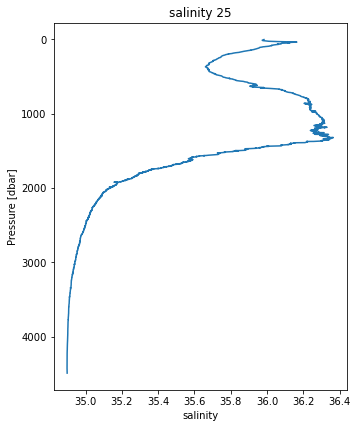

In [88]:
vert_profile(data, '25', 'salinity', savefig=True)

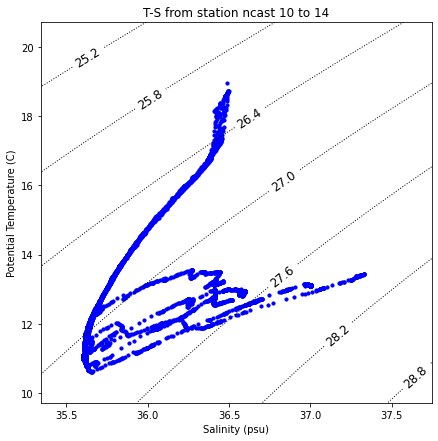

In [109]:
nlist=['10','11','12','13','14']
plot_TS(data, nlist, savefig=True)

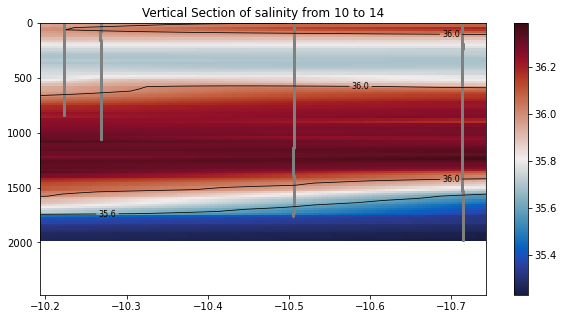

In [122]:
import cmocean
n_list = ['21','22','23','24']
variable = 'salinity'
function_interp = 'linear'
cmap = cmocean.cm.balance

vert_section(data, n_list, variable, function_interp, cmap, savefig=True, ncontours=2)